# Unsupervised Learning

In unsupervised learning, the task is to infer hidden structure from
unlabeled data, comprised of training examples $\{x_n\}$.

We demonstrate with an example in Edward. A webpage version is available at
http://edwardlib.org/tutorials/unsupervised.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import six
import tensorflow as tf
ed.set_seed(42)
from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture)

plt.style.use('ggplot')

/afs/inf.ed.ac.uk/user/s12/s1202144/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


## Data

Use a simulated data set of 2-dimensional data points
$\mathbf{x}_n\in\mathbb{R}^2$.

In [2]:
def build_toy_dataset(N):
  pi = np.array([0.4, 0.6])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x


N = 500  # number of data points
K = 2  # number of components
D = 2  # dimensionality of data


x_train = build_toy_dataset(N)

We visualize the generated data points.

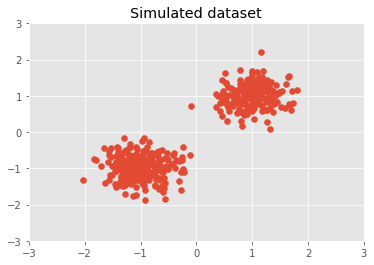

In [3]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.title("Simulated dataset")
plt.show()

## Model

A mixture model is a model typically used for clustering.
It assigns a mixture component to each data point, and this mixture component
determines the distribution that the data point is generated from. A
mixture of Gaussians uses Gaussian distributions to generate this data
(Bishop, 2006).

For a set of $N$ data points,
the likelihood of each observation $\mathbf{x}_n$ is

\begin{align*}
  p(\mathbf{x}_n \mid \pi, \mu, \sigma)
  &=
  \sum_{k=1}^K \pi_k \, \text{Normal}(\mathbf{x}_n \mid \mu_k, \sigma_k).
\end{align*}

The latent variable $\pi$ is a $K$-dimensional probability vector
which mixes individual Gaussian distributions, each
characterized by a mean $\mu_k$ and standard deviation $\sigma_k$.

Define the prior on $\pi\in[0,1]$ such that $\sum_{k=1}^K\pi_k=1$ to be

\begin{align*}
  p(\pi)
  &=
  \text{Dirichlet}(\pi \mid \alpha \mathbf{1}_{K})
\end{align*}

for fixed $\alpha=1$. Define the prior on each component $\mathbf{\mu}_k\in\mathbb{R}^D$ to be

\begin{align*}
  p(\mathbf{\mu}_k)
  &=
  \text{Normal}(\mathbf{\mu}_k \mid \mathbf{0}, \mathbf{I}).
\end{align*}

Define the prior on each component $\mathbf{\sigma}_k^2\in\mathbb{R}^D$ to be

\begin{align*}
  p(\mathbf{\sigma}_k^2)
  &=
  \text{InverseGamma}(\mathbf{\sigma}_k^2 \mid a, b).
\end{align*}

We build two versions of the model in Edward: one jointly with the
mixture assignments $c_n\in\{0,\ldots,K-1\}$ as latent variables,
and another with them summed out.

The joint version includes an explicit latent variable for the mixture
assignments. We implement this with the `ParamMixture` random
variable; it takes as input the mixing probabilities, the components'
parameters, and the distribution of the components. It is the
distribution of the mixture conditional on mixture assignments. (Note
we can also write this separately by first building a `Categorical`
random variable for `z` and then building `x`; `ParamMixture` avoids
requiring `tf.gather` which is slightly more efficient.)

In [4]:
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

The collapsed version marginalizes out the mixture assignments. We
implement this with the `Mixture` random variable; it takes as
input a Categorical distribution and a list of individual distribution
components. It is the distribution of the mixture summing out the
mixture assignments. Gibbs sampling does not work with `Mixture` random
variables, please try an alternative.

In [5]:
"""
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
cat = Categorical(probs=pi, sample_shape=N)
components = [
    MultivariateNormalDiag(mu[k], tf.sqrt(sigmasq[k]), sample_shape=N)
    for k in range(K)]
x = Mixture(cat=cat, components=components)
"""

'\npi = Dirichlet(tf.ones(K))\nmu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)\nsigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)\ncat = Categorical(probs=pi, sample_shape=N)\ncomponents = [\n    MultivariateNormalDiag(mu[k], tf.sqrt(sigmasq[k]), sample_shape=N)\n    for k in range(K)]\nx = Mixture(cat=cat, components=components)\n'

We will use the joint version in this analysis.

## Inference

Each distribution in the model is written with conjugate priors, so we
can use Gibbs sampling. It performs Markov chain Monte Carlo by
iterating over draws from the complete conditionals of each
distribution, i.e., each distribution conditional on a previously
drawn value. First we set up Empirical random variables which will
approximate the posteriors using the collection of samples.

In [6]:
T = 500  # number of MCMC samples
qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

ValueError: Variable qpi/params already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-5-6badde4423dd>", line 4, in <module>
    initializer=tf.constant_initializer(1.0 / K)))
  File "/afs/inf.ed.ac.uk/user/s12/s1202144/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/afs/inf.ed.ac.uk/user/s12/s1202144/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):


Run Gibbs sampling. We write the training loop explicitly, so that we can track
the cluster means as the sampler progresses.

In [7]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  if t % inference.n_print == 0:
    print("\nInferred cluster means:")
    print(sess.run(running_cluster_means, {t_ph: t - 1}))

/afs/inf.ed.ac.uk/user/s12/s1202144/miniconda3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


  5/500 [  1%]                                ETA: 60s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.2759056   0.36513087]
 [-0.57515204 -0.4851961 ]]
 10/500 [  2%]                                ETA: 34s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.6337332   0.6816196 ]
 [-0.8102343  -0.74457484]]
 15/500 [  3%]                                ETA: 23s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.7600507   0.79856604]
 [-0.87815946 -0.8262308 ]]
 20/500 [  4%] █                              ETA: 18s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.821256    0.8551938 ]
 [-0.91282445 -0.860884  ]]
 25/500 [  5%] █                              ETA: 15s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.8576469   0.8930318 ]
 [-0.9333708  -0.88464355]]
 30/500 [  6%] █                              ETA: 13s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.8774287   0.91293865]
 [-0.9463699  -0.897863  ]]
 35/500 [  7%] ██                             

265/500 [ 53%] ███████████████                ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.9711179   1.0124334 ]
 [-1.0044497  -0.96194506]]
270/500 [ 54%] ████████████████               ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.97086877  1.0128866 ]
 [-1.0043904  -0.9620452 ]]
275/500 [ 55%] ████████████████               ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.97129875  1.0127695 ]
 [-1.0043272  -0.96208817]]
280/500 [ 56%] ████████████████               ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.97162545  1.0129387 ]
 [-1.0045155  -0.9624618 ]]
285/500 [ 56%] █████████████████              ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.9720257   1.0131354 ]
 [-1.0048826  -0.96251947]]
290/500 [ 57%] █████████████████              ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.97226524  1.0134531 ]
 [-1.0052773  -0.9625787 ]]
295/500 [ 59%] █████████████████              ETA: 2

In [8]:
sess.run(qmu.sample(100))

array([[[ 0.9486212 ,  1.0353546 ],
        [-1.006353  , -0.9584221 ]],

       [[ 1.0037618 ,  1.0459365 ],
        [-1.0137264 , -0.9877131 ]],

       [[ 0.96683514,  0.97743946],
        [-1.0437274 , -0.9677285 ]],

       [[ 0.9296166 ,  1.0330362 ],
        [-0.9956963 , -0.9401065 ]],

       [[ 0.973614  ,  1.0387613 ],
        [-0.9997834 , -0.95591336]],

       [[ 1.004651  ,  1.0009398 ],
        [-1.0380948 , -0.969842  ]],

       [[ 0.9872291 ,  0.9999682 ],
        [-1.0564986 , -0.974731  ]],

       [[ 0.95448864,  1.0246148 ],
        [-1.0039816 , -0.9606948 ]],

       [[ 0.9743077 ,  1.0120431 ],
        [-0.9566615 , -0.98715425]],

       [[ 0.9817158 ,  1.0114447 ],
        [-1.0063792 , -0.9670093 ]],

       [[ 0.04662272,  0.15252519],
        [-0.41019896, -0.32822242]],

       [[ 1.0300987 ,  1.0409484 ],
        [-1.0477569 , -0.97947454]],

       [[ 0.9837777 ,  1.046701  ],
        [-0.97061986, -0.9380374 ]],

       [[ 0.95364654,  1.0458056 ],
  

## Criticism

We visualize the predicted memberships of each data point. We pick
the cluster assignment which produces the highest posterior predictive
density for each data point.

To do this, we first draw a sample from the posterior and calculate a
a $N\times K$ matrix of log-likelihoods, one for each data point
$\mathbf{x}_n$ and cluster assignment $k$.
We perform this averaged over 100 posterior samples.

In [16]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
print(log_liks)
log_liks = tf.reduce_sum(log_liks, 3)
print(log_liks)
log_liks = tf.reduce_mean(log_liks, 1)
print(log_liks)

Tensor("Normal_3/log_prob/sub:0", shape=(500, 100, 2, 2), dtype=float32)
Tensor("Sum_2:0", shape=(500, 100, 2), dtype=float32)
Tensor("Mean_3:0", shape=(500, 2), dtype=float32)


We then take the $\arg\max$ along the columns (cluster assignments).

In [10]:
# Choose the cluster with the highest likelihood for each data point.
clusters = tf.argmax(log_liks, 1).eval()

In [17]:
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,

Plot the data points, colored by their predicted membership.

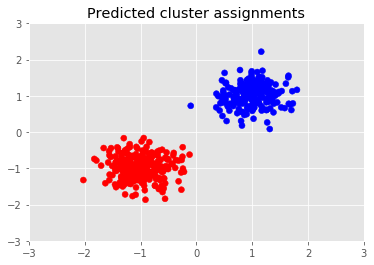

In [11]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

The model has correctly clustered the data.

## Remarks: The log-sum-exp trick

For a collapsed mixture model, implementing the log density can be tricky.
In general, the log density is

\begin{align*}
  \log p(\pi) +
  \Big[ \sum_{k=1}^K \log p(\mathbf{\mu}_k) + \log
  p(\mathbf{\sigma}_k) \Big] +
  \sum_{n=1}^N \log p(\mathbf{x}_n \mid \pi, \mu, \sigma),
\end{align*}

where the likelihood is

\begin{align*}
  \sum_{n=1}^N \log p(\mathbf{x}_n \mid \pi, \mu, \sigma)
  &=
  \sum_{n=1}^N \log \sum_{k=1}^K \pi_k \, \text{Normal}(\mathbf{x}_n \mid
  \mu_k, \sigma_k).
\end{align*}

To prevent numerical instability, we'd like to work on the log-scale,

\begin{align*}
  \sum_{n=1}^N \log p(\mathbf{x}_n \mid \pi, \mu, \sigma)
  &=
  \sum_{n=1}^N \log \sum_{k=1}^K \exp\Big(
  \log \pi_k + \log \text{Normal}(\mathbf{x}_n \mid \mu_k, \sigma_k)\Big).
\end{align*}

This expression involves a log sum exp operation, which is
numerically unstable as exponentiation will often lead to one value
dominating the rest. Therefore we use the log-sum-exp trick.
It is based on the identity

\begin{align*}
  \mathbf{x}_{\mathrm{max}}
  &=
  \arg\max \mathbf{x},
  \\
  \log \sum_i \exp(\mathbf{x}_i)
  &=
  \log \Big(\exp(\mathbf{x}_{\mathrm{max}}) \sum_i \exp(\mathbf{x}_i -
  \mathbf{x}_{\mathrm{max}})\Big)
  \\
  &=
  \mathbf{x}_{\mathrm{max}} + \log \sum_i \exp(\mathbf{x}_i -
  \mathbf{x}_{\mathrm{max}}).
\end{align*}

Subtracting the maximum value before taking the log-sum-exp leads to
more numerically stable output. The $\texttt{Mixture}$ random variable
implements this trick for calculating the log-density.